# Method: Koopman Autoencoders
# Dataset: KS Equation, L = 60
# Purpose: Prediction

# 1. Set-up

In [13]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Package
import sys
sys.path.append("../..")

In [14]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time, localtime, strftime

from functools import partial

import jax
from jax import jit, value_and_grad
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
import jax.example_libraries.stax as stax
from jax.example_libraries.stax import Dense, Relu, Tanh
from jax.nn.initializers import glorot_normal

In [15]:
SEED = 42

In [16]:
train, test = load_data("KS, L = 60", "../../data/ks60", 0.5)

In [17]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 240)
Test size: (90000, 240)


**Create test set**

In [18]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [19]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [20]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 240)
Test output size: (100, 400, 240)


# 2. Koopman Autoencoder Implementation

In [21]:
def Dense_no_bias(out_dim, W_init = glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W = W_init(k1, (input_shape[-1], out_dim))
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

In [22]:
def get_params(hidden_state_list, max_lag, lambda_list, seed, batch_size, num_epoch, lr_schedule, 
               early_stopping = EARLY_STOPPING):
    assert len(num_epoch) == len(lr_schedule)
    
    def create_network():
        encoder_init, encoder = stax.serial(
            Dense(p1), Tanh,  
            Dense(p2), Tanh,
            Dense(p3), Tanh,
            Dense(kappa))
        decoder_init, decoder = stax.serial(
            Dense(p3), Tanh,
            Dense(p2), Tanh,
            Dense(p1), Tanh,
            Dense(data_dim))
        forward_init, forward = stax.serial(
            Dense_no_bias(kappa))
        backward_init, backward = stax.serial(
            Dense_no_bias(kappa))

        # initialization
        enc_init_rng, dec_init_rng, forward_init_rng, backward_init_rng = random.split(key, num = 4)

        enc_in_shape = (-1, data_dim)
        dec_in_shape = (-1, kappa)
        forward_in_shape = (-1, kappa)
        backward_in_shape = (-1, kappa)
        _, enc_params = encoder_init(enc_init_rng, enc_in_shape)
        _, dec_params = decoder_init(dec_init_rng, dec_in_shape)
        _, fwd_params = forward_init(forward_init_rng, forward_in_shape)
        _, bwd_params = backward_init(backward_init_rng, backward_in_shape)

        network = (encoder, decoder, forward, backward)
        params = (enc_params, dec_params, fwd_params, bwd_params)
        return network, params
    
    def training(init_params):
        @jit
        def loss(params, batch):
            """
            each batch has dimension Batch_size x (max_lag+1) x dim
            """
            # unpack parameters
            enc_params, dec_params, fwd_params, bwd_params = params
            lambda_id, lambda_fwd, lambda_bwd, lambda_con = lambda_list

            loss_id, loss_fwd, loss_bwd, loss_con = 0, 0, 0, 0

            # AUTOENCODER
            f_start = batch[:,0,:]
            f_target = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            f_predict = decoder(dec_params, f_encoded)
            loss_id = 0.5 * jnp.mean((f_predict - f_target)**2)

            # FORWARD
            f_start = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag+ 1):
                # simulate forward
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,t_steps,:]
                loss_fwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_fwd = loss_fwd / max_lag

            # BACKWARD
            f_start = batch[:,-1,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag + 1):
                f_encoded = backward(bwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,-t_steps-1,:]
                loss_bwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_bwd = loss_bwd / max_lag

            # CONSISTENT
            for k in range(1, kappa + 1):
                C_upper = fwd_params[0][:k, :]
                D_left = bwd_params[0][:, :k]
                C_left = fwd_params[0][:, :k]
                D_upper = bwd_params[0][:k, :]

                I_k = jnp.identity(k)

                loss_con += (jnp.sum((D_upper @ C_left - I_k)**2) + jnp.sum((C_upper @ D_left - I_k)**2)) / (2 * k)

            return lambda_id * loss_id + lambda_fwd * loss_fwd + lambda_bwd * loss_bwd + lambda_con * loss_con
    
        @jit
        def step(i, opt_state, batch):
            params = get_params(opt_state)
            value, g = value_and_grad(loss)(params, batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        def make_forecast(params, batch, L_forecast):
            enc_params, dec_params, fwd_params, bwd_params = params

            preds = []
            f_start = batch[:, 0, :]
            f_encoded = encoder(enc_params, f_start)
            for t in range(L_forecast):
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                preds.append(f_predict)
            return np.swapaxes(preds, 0, 1)      
        
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE. Primarily used for validation calculation

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast_test)
            
            #compute MSE
            error = y_pred - y_truth
            mu_loss = np.mean(error**2)
            return mu_loss 
        
        start = time()
        best_params = init_params
        overall_best_mse = 99999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + max_lag))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(max_lag)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(max_lag, max_lag + L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the data
                T_indices = np.arange(t_size - max_lag - 1)
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch

                    # create 2d array of dimension (batch_size, max_lag + 1) containing all the time indices
                    t_batch = (t_start[:,None] + np.arange(max_lag + 1)[None,:]).astype(int) # transposes data

                    #create batch of dimension (batch_size,  max_lag + 1, data_dim)
                    x_batch = x[t_batch]  

                    params, opt_state, loss_current = step(k, opt_state, x_batch)
                    loss_epoch_train.append(loss_current.item())
                
                mse_train = np.mean(loss_epoch_train)

                # validation
                mse_val = mse(params, x_val, y_val)
                
                if best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 30):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                if counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
            
        end = time()
        print(f"Total time: {end - start:.2f}")

        return overall_best_params
            
    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    p1, p2, p3, kappa = hidden_state_list # 4 layers (including bottleneck)
        
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    (encoder, decoder, forward, backward), params = create_network()
    final_params = training(params)
    
    return final_params, (encoder, decoder, forward, backward)

In [23]:
def get_test_pred(data_test, params, network):
    start = time()
    
    (encoder, decoder, forward, backward) = network
    enc_params, dec_params, fwd_params, bwd_params = params
    
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data

    preds = []
    f_start = data_test[:, 0, :]
    f_encoded = encoder(enc_params, f_start)
    for t in range(L_forecast_test):
        f_encoded = forward(fwd_params, f_encoded)
        f_predict = decoder(dec_params, f_encoded)
        preds.append(f_predict)
    end = time()
    print(f"Time taken: {end - start:.2f}")
    return np.swapaxes(preds, 0, 1)

# 3. Parameter tuning

There are 3 parameters to tune
- hidden_size - size of the hidden layer
- max_lag - Number of steps calculated for forward and backward dynamics
- loss_weights - [encoder, forward, backward, consistent] loss

## 3.1 hidden_size

**Parameters**
- hidden_size varied
- max_lag = 8
- loss_weights = [1, 1, 0.1, 0.01]

In [24]:
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [25]:
res_folder = os.path.join("results", "koopman")

### 3.1.1 hidden_size = [128, 64, 32, 16]

In [26]:
hidden_size = [128, 64, 32, 16]

In [27]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.39 | Train loss = 0.1537630 | Val loss =  1.9172797
Epoch 20: Time taken = 3.42 | Train loss = 0.1190143 | Val loss =  1.7694516
Epoch 30: Time taken = 3.42 | Train loss = 0.1099343 | Val loss =  1.8297948
EARLY STOPPING. Epoch 31: Train loss = 0.1092984 | Val loss =  1.8586492
Best Validation MSE: 1.0005251
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.34 | Train loss = 0.1398958 | Val loss =  1.9672748
Epoch 20: Time taken = 3.34 | Train loss = 0.1167182 | Val loss =  1.7540836
Epoch 30: Time taken = 3.31 | Train loss = 0.1081383 | Val loss =  1.8336456
EARLY STOPPING. Epoch 31: Train loss = 0.1075198 | Val loss =  1.8044055
Best Validation MSE: 1.6364918

Epoch 10: Time taken = 3.23 | Train loss = 0.1337219 | Val loss =  1.9513334
Epoch 20: Time taken = 3.22 | Train loss = 0.1148543 | Val loss =  1.7850664
Epoch 30: Time taken = 3.26 | Train loss = 0.1070153 | Val loss =  1.7902302
Epoch 40: Time taken = 3.35 | Train loss = 0.10117

In [28]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 1.02


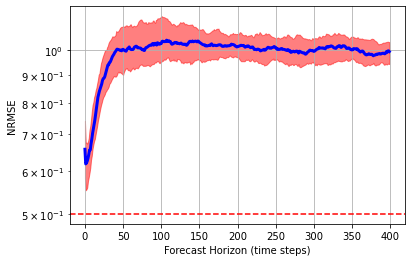

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 5: 0.850
Median NRMSE at t = 10: 0.994
Median NRMSE at t = 20: 1.011
Median NRMSE at t = 50: 1.015
Median NRMSE at t = 99: 0.991


In [29]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.2 hidden_size = [100, 50, 24, 12]

In [33]:
hidden_size = [100, 50, 24, 12]

In [34]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.35 | Train loss = 0.2845775 | Val loss =  2.0223659
Epoch 20: Time taken = 3.52 | Train loss = 0.2481803 | Val loss =  1.8086418
Epoch 30: Time taken = 3.93 | Train loss = 0.2098104 | Val loss =  1.8226802
EARLY STOPPING. Epoch 34: Train loss = 0.2039562 | Val loss =  1.8460781
Best Validation MSE: 1.2867547
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.73 | Train loss = 0.2623608 | Val loss =  1.7968581
Epoch 20: Time taken = 3.61 | Train loss = 0.2251537 | Val loss =  1.8387712
Epoch 30: Time taken = 4.17 | Train loss = 0.2030786 | Val loss =  1.8305405
EARLY STOPPING. Epoch 32: Train loss = 0.2015971 | Val loss =  1.8589235
Best Validation MSE: 1.6314181

Epoch 10: Time taken = 3.80 | Train loss = 0.2527806 | Val loss =  1.9474098
Epoch 20: Time taken = 3.73 | Train loss = 0.2136479 | Val loss =  2.1244100
Epoch 30: Time taken = 3.78 | Train loss = 0.2010501 | Val loss =  1.9197008
Epoch 40: Time taken = 3.58 | Train loss = 0.19332

In [35]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 1.07


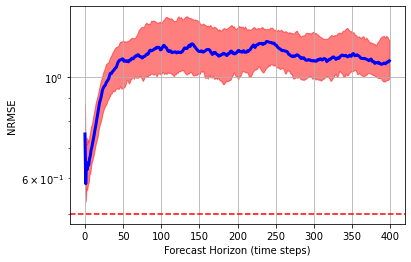

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 5: 0.888
Median NRMSE at t = 10: 1.049
Median NRMSE at t = 20: 1.120
Median NRMSE at t = 50: 1.140
Median NRMSE at t = 99: 1.078


In [36]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.3 hidden_size = [160, 128, 64, 32]

In [37]:
hidden_size = [160, 128, 64, 32]

In [38]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 4.38 | Train loss = 0.0796922 | Val loss =  2.0259206
Epoch 20: Time taken = 4.40 | Train loss = 0.0669077 | Val loss =  2.0200274
Epoch 30: Time taken = 4.62 | Train loss = 0.0505126 | Val loss =  2.1687904
EARLY STOPPING. Epoch 31: Train loss = 0.0497364 | Val loss =  2.4447497
Best Validation MSE: 0.9961429
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.67 | Train loss = 0.0765811 | Val loss =  1.9364403
Epoch 20: Time taken = 4.40 | Train loss = 0.0635686 | Val loss =  2.0331389
Epoch 30: Time taken = 4.35 | Train loss = 0.0489566 | Val loss =  2.2003087
EARLY STOPPING. Epoch 31: Train loss = 0.0482677 | Val loss =  2.2031300
Best Validation MSE: 1.9055411

Epoch 10: Time taken = 4.47 | Train loss = 0.0737052 | Val loss =  2.0147867
Epoch 20: Time taken = 4.63 | Train loss = 0.0585794 | Val loss =  1.9986853
Epoch 30: Time taken = 4.47 | Train loss = 0.0478939 | Val loss =  2.1950079
EARLY STOPPING. Epoch 39: Train loss = 0.0412670 |

In [39]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.47


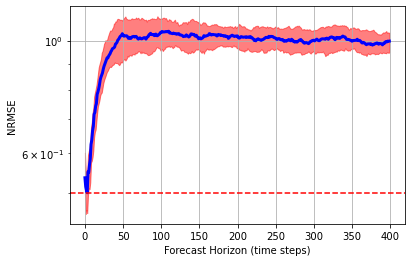

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.836
Median NRMSE at t = 0.5: 1.026
Median NRMSE at t = 1: 1.038
Median NRMSE at t = 2: 1.021
Median NRMSE at t = 3: 1.001


In [40]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 hidden_size = [200, 160, 128, 96]

In [41]:
hidden_size = [200, 160, 128, 96]

In [42]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 8.11 | Train loss = 0.0134046 | Val loss =  2.6113567
Epoch 20: Time taken = 8.07 | Train loss = 0.0081938 | Val loss =  2.6521491
Epoch 30: Time taken = 7.91 | Train loss = 0.0063785 | Val loss =  nan
EARLY STOPPING. Epoch 31: Train loss = 0.0062465 | Val loss =  2.7160399
Best Validation MSE: 1.0847780
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 7.89 | Train loss = 0.0117654 | Val loss =  2.7402291
Epoch 20: Time taken = 8.02 | Train loss = 0.0078587 | Val loss =  nan
Epoch 30: Time taken = 8.18 | Train loss = 0.0060965 | Val loss =  nan
EARLY STOPPING. Epoch 31: Train loss = 0.0059310 | Val loss =  nan
Best Validation MSE: 2.1266603

Epoch 10: Time taken = 7.28 | Train loss = 0.0106100 | Val loss =  2.9419928
Epoch 20: Time taken = 7.06 | Train loss = 0.0073969 | Val loss =  nan
Epoch 30: Time taken = 6.96 | Train loss = 0.0058074 | Val loss =  nan
EARLY STOPPING. Epoch 31: Train loss = 0.0056959 | Val loss =  nan
Best Validation MSE

In [43]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.70


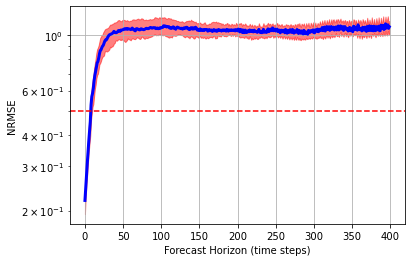

It takes around t = 0.08 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.867
Median NRMSE at t = 0.5: 1.050
Median NRMSE at t = 1: 1.069
Median NRMSE at t = 2: 1.038
Median NRMSE at t = 3: 1.022


In [44]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 hidden_size = [200, 176, 160, 144]

In [14]:
hidden_size = [200, 176, 160, 144]

In [15]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 11.19 | Train loss = 0.0112389 | Val loss =  2.4850688
Epoch 20: Time taken = 10.83 | Train loss = 0.0062274 | Val loss =  2.2206340
Epoch 30: Time taken = 10.96 | Train loss = 0.0049646 | Val loss =  nan
EARLY STOPPING. Epoch 31: Train loss = 0.0049311 | Val loss =  nan
Best Validation MSE: 1.0699521
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 11.06 | Train loss = 0.0093857 | Val loss =  2.3292435
Epoch 20: Time taken = 11.27 | Train loss = 0.0059021 | Val loss =  2.2320599
Epoch 30: Time taken = 11.18 | Train loss = 0.0048380 | Val loss =  2.0216497
EARLY STOPPING. Epoch 31: Train loss = 0.0047226 | Val loss =  2.0183474
Best Validation MSE: 1.7706667

Epoch 10: Time taken = 10.75 | Train loss = 0.0082061 | Val loss =  2.1760455
Epoch 20: Time taken = 10.53 | Train loss = 0.0056310 | Val loss =  2.1625800
Epoch 30: Time taken = 10.67 | Train loss = 0.0047122 | Val loss =  2.0630821
Epoch 38: Time taken = 10.65 | Train loss = 0.0043483

In [16]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 1.13


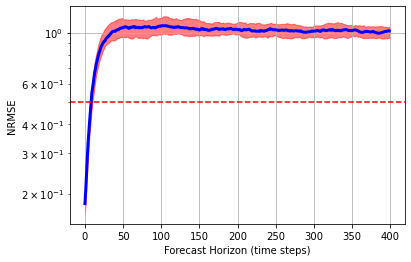

It takes around t = 0.08 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.842
Median NRMSE at t = 0.5: 1.049
Median NRMSE at t = 1: 1.068
Median NRMSE at t = 2: 1.030
Median NRMSE at t = 3: 1.014


In [17]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.6 hidden_size = [240, 240, 240, 240]

In [14]:
hidden_size = [240, 240, 240, 240]

In [15]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 17.48 | Train loss = 0.0078814 | Val loss =  1.7572579
Epoch 20: Time taken = 19.38 | Train loss = 0.0052719 | Val loss =  2.0890397
Epoch 30: Time taken = 19.42 | Train loss = 0.0041973 | Val loss =  1.6660114
EARLY STOPPING. Epoch 31: Train loss = 0.0039982 | Val loss =  1.6827454
Best Validation MSE: 1.2303958
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 19.45 | Train loss = 0.0068485 | Val loss =  1.7771049
Epoch 20: Time taken = 19.31 | Train loss = 0.0048132 | Val loss =  2.2046116
Epoch 30: Time taken = 19.06 | Train loss = 0.0039838 | Val loss =  1.4944962
Epoch 32: Time taken = 19.39 | Train loss = 0.0037386 | Val loss =  1.4853623
Epoch 33: Time taken = 18.87 | Train loss = 0.0037245 | Val loss =  1.4832393
Epoch 37: Time taken = 19.15 | Train loss = 0.0034384 | Val loss =  1.4678783
Epoch 38: Time taken = 18.83 | Train loss = 0.0034993 | Val loss =  1.4500447
Epoch 40: Time taken = 18.78 | Train loss = 0.0033023 | Val loss =  

In [16]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.42


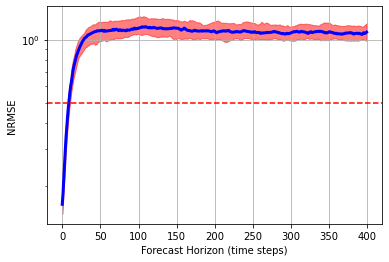

It takes around t = 0.09 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.860
Median NRMSE at t = 0.5: 1.104
Median NRMSE at t = 1: 1.130
Median NRMSE at t = 2: 1.095
Median NRMSE at t = 3: 1.077


In [17]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 max_lag

In [45]:
loss_weights = [1, 1, .1, .01]
hidden_size = [240, 240, 240, 240]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.2.1 max_lag = 4

In [46]:
max_lag = 4

In [47]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 16.44 | Train loss = 0.0044901 | Val loss =  2.6261858
Epoch 20: Time taken = 16.28 | Train loss = 0.0032530 | Val loss =  2.2236511
Epoch 30: Time taken = 16.33 | Train loss = 0.0027601 | Val loss =  1.9171187
EARLY STOPPING. Epoch 31: Train loss = 0.0026990 | Val loss =  1.9184187
Best Validation MSE: 1.4615582
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 16.47 | Train loss = 0.0042346 | Val loss =  2.4752977
Epoch 20: Time taken = 16.47 | Train loss = 0.0031207 | Val loss =  1.9990724
Epoch 30: Time taken = 16.31 | Train loss = 0.0025836 | Val loss =  1.9088579
EARLY STOPPING. Epoch 31: Train loss = 0.0024986 | Val loss =  1.8937856
Best Validation MSE: 1.6171149

Epoch 10: Time taken = 16.26 | Train loss = 0.0037864 | Val loss =  2.4496503
Epoch 20: Time taken = 16.58 | Train loss = 0.0029714 | Val loss =  1.9534698
Epoch 30: Time taken = 16.46 | Train loss = 0.0025508 | Val loss =  1.9501188
EARLY STOPPING. Epoch 31: Train loss = 0.

In [48]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.40


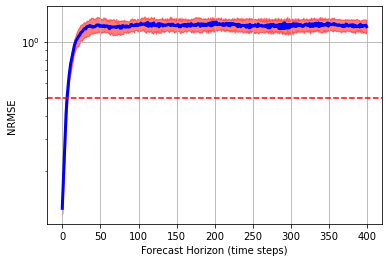

It takes around t = 0.07 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 1.042
Median NRMSE at t = 0.5: 1.209
Median NRMSE at t = 1: 1.227
Median NRMSE at t = 2: 1.272
Median NRMSE at t = 3: 1.209


In [49]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 max_lag = 8
This is already done in 3.1.6

### 3.2.3 max_lag = 16

In [50]:
max_lag = 16

In [51]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 20.22 | Train loss = 0.0198139 | Val loss =  2.0335728
Epoch 20: Time taken = 19.55 | Train loss = 0.0128512 | Val loss =  2.2117846
Epoch 30: Time taken = 16.88 | Train loss = 0.0100527 | Val loss =  2.1970187
EARLY STOPPING. Epoch 31: Train loss = 0.0099614 | Val loss =  2.2601677
Best Validation MSE: 1.0330933
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 16.86 | Train loss = 0.0173361 | Val loss =  1.9594548
Epoch 20: Time taken = 16.92 | Train loss = 0.0119761 | Val loss =  2.1798522
Epoch 30: Time taken = 16.87 | Train loss = 0.0096845 | Val loss =  1.5756856
Epoch 31: Time taken = 16.85 | Train loss = 0.0095328 | Val loss =  1.5056996
Epoch 35: Time taken = 17.02 | Train loss = 0.0086505 | Val loss =  1.4933422
Epoch 40: Time taken = 16.77 | Train loss = 0.0080077 | Val loss =  1.6276261
Epoch 50: Time taken = 16.77 | Train loss = 0.0071918 | Val loss =  1.6261665
Best Validation MSE: 1.4933422

Epoch 10: Time taken = 16.86 | Train

In [52]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.22


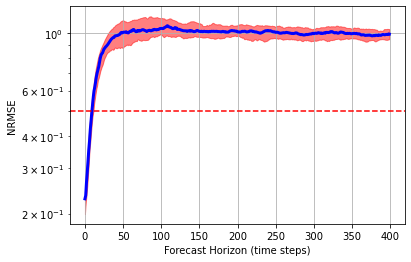

It takes around t = 0.10 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.800
Median NRMSE at t = 0.5: 1.010
Median NRMSE at t = 1: 1.047
Median NRMSE at t = 2: 1.014
Median NRMSE at t = 3: 0.998


In [53]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 max_lag = 24

In [19]:
max_lag = 24

In [20]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 21.37 | Train loss = 0.0406690 | Val loss =  1.8047752
Epoch 20: Time taken = 21.64 | Train loss = 0.0265228 | Val loss =  1.9167129
Epoch 30: Time taken = 21.75 | Train loss = 0.0205223 | Val loss =  2.0066521
EARLY STOPPING. Epoch 31: Train loss = 0.0199729 | Val loss =  2.0388310
Best Validation MSE: 1.0185136
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 21.71 | Train loss = 0.0362927 | Val loss =  1.7982463
Epoch 20: Time taken = 21.71 | Train loss = 0.0241049 | Val loss =  2.0188999
Epoch 30: Time taken = 22.19 | Train loss = 0.0195529 | Val loss =  2.1160589
EARLY STOPPING. Epoch 34: Train loss = 0.0177098 | Val loss =  2.2057423
Best Validation MSE: 1.5521401

Epoch 10: Time taken = 21.59 | Train loss = 0.0284977 | Val loss =  1.9825764
Epoch 20: Time taken = 21.87 | Train loss = 0.0212064 | Val loss =  1.9933765
Epoch 30: Time taken = 21.07 | Train loss = 0.0173001 | Val loss =  2.1190316
EARLY STOPPING. Epoch 31: Train loss = 0.

In [21]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.27


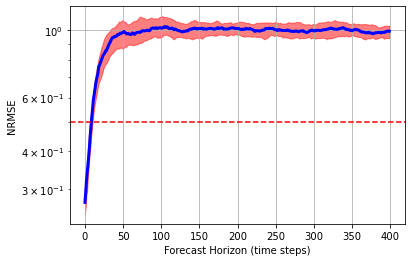

It takes around t = 0.09 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.778
Median NRMSE at t = 0.5: 0.986
Median NRMSE at t = 1: 1.017
Median NRMSE at t = 2: 1.014
Median NRMSE at t = 3: 0.997


In [22]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 max_lag = 32

In [19]:
max_lag = 32

In [20]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 21.27 | Train loss = 0.0709269 | Val loss =  1.6542635
Epoch 20: Time taken = 21.22 | Train loss = 0.0474063 | Val loss =  1.6848744
Epoch 30: Time taken = 21.15 | Train loss = 0.0384077 | Val loss =  1.7187428
EARLY STOPPING. Epoch 31: Train loss = 0.0375555 | Val loss =  1.7401029
Best Validation MSE: 1.0101578
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 21.07 | Train loss = 0.0635751 | Val loss =  1.7131750
Epoch 20: Time taken = 21.46 | Train loss = 0.0444229 | Val loss =  1.8063141
Epoch 30: Time taken = 21.58 | Train loss = 0.0361429 | Val loss =  1.8337242
EARLY STOPPING. Epoch 31: Train loss = 0.0362729 | Val loss =  1.7743491
Best Validation MSE: 1.0448012

Epoch 10: Time taken = 21.50 | Train loss = 0.0589460 | Val loss =  1.7230347
Epoch 20: Time taken = 21.18 | Train loss = 0.0429615 | Val loss =  1.8622184
Epoch 30: Time taken = 21.23 | Train loss = 0.0354282 | Val loss =  1.8128791
EARLY STOPPING. Epoch 31: Train loss = 0.

In [21]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.38


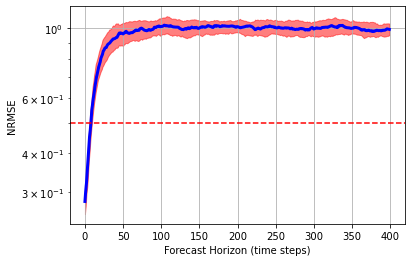

It takes around t = 0.08 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.781
Median NRMSE at t = 0.5: 0.959
Median NRMSE at t = 1: 1.013
Median NRMSE at t = 2: 1.011
Median NRMSE at t = 3: 0.994


In [22]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 Loss coefficients

In [54]:
hidden_size = [240, 240, 240, 240]
max_lag = 16

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.3.1 Base [1, 1, 0.1, 0.01]
This is done in 3.2.3

### 3.3.2 Increased focus on forward loss [1, 2, 0.1, 0.01]

In [56]:
loss_weights = [1, 2, .1, .01]

In [57]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 19.11 | Train loss = 0.0291803 | Val loss =  1.8258346
Epoch 20: Time taken = 19.31 | Train loss = 0.0194285 | Val loss =  2.0603490
Epoch 30: Time taken = 19.05 | Train loss = 0.0155865 | Val loss =  2.2002921
EARLY STOPPING. Epoch 31: Train loss = 0.0151016 | Val loss =  2.2039763
Best Validation MSE: 1.1228334
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 19.34 | Train loss = 0.0258383 | Val loss =  2.0490847
Epoch 20: Time taken = 19.35 | Train loss = 0.0179414 | Val loss =  2.1030351
Epoch 30: Time taken = 19.19 | Train loss = 0.0145166 | Val loss =  1.9190586
EARLY STOPPING. Epoch 37: Train loss = 0.0133578 | Val loss =  2.0595509
Best Validation MSE: 1.8239740

Epoch 10: Time taken = 19.34 | Train loss = 0.0191983 | Val loss =  1.9951961
Epoch 20: Time taken = 19.04 | Train loss = 0.0149836 | Val loss =  1.9969765
Epoch 30: Time taken = 19.21 | Train loss = 0.0127954 | Val loss =  2.1920828
Epoch 35: Time taken = 19.29 | Train loss

In [58]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.23


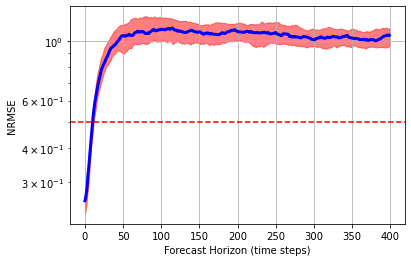

It takes around t = 0.11 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.745
Median NRMSE at t = 0.5: 1.046
Median NRMSE at t = 1: 1.105
Median NRMSE at t = 2: 1.085
Median NRMSE at t = 3: 1.011


In [59]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 Only autoencoder and forward loss [1, 1, 0, 0]

In [60]:
loss_weights = [1, 1, 0, 0]

In [61]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 16.35 | Train loss = 0.0120494 | Val loss =  2.0547319
Epoch 20: Time taken = 16.46 | Train loss = 0.0074009 | Val loss =  2.1848870
Epoch 30: Time taken = 16.46 | Train loss = 0.0058482 | Val loss =  2.2674120
EARLY STOPPING. Epoch 31: Train loss = 0.0056164 | Val loss =  2.2838541
Best Validation MSE: 1.0503188
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 16.39 | Train loss = 0.0103846 | Val loss =  1.9534483
Epoch 20: Time taken = 16.49 | Train loss = 0.0068653 | Val loss =  2.2755553
Epoch 30: Time taken = 16.46 | Train loss = 0.0054011 | Val loss =  2.3062742
EARLY STOPPING. Epoch 31: Train loss = 0.0053022 | Val loss =  2.3464392
Best Validation MSE: 1.7912458

Epoch 10: Time taken = 16.40 | Train loss = 0.0092588 | Val loss =  2.0332269
Epoch 20: Time taken = 16.47 | Train loss = 0.0063022 | Val loss =  2.3100011
Epoch 30: Time taken = 16.41 | Train loss = 0.0050789 | Val loss =  2.2964140
EARLY STOPPING. Epoch 31: Train loss = 0.

In [62]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.23


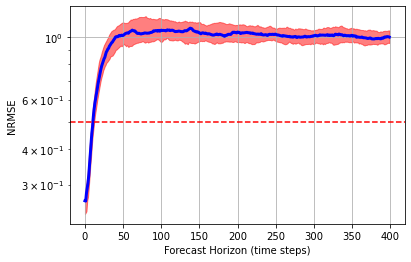

It takes around t = 0.11 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.748
Median NRMSE at t = 0.5: 1.011
Median NRMSE at t = 1: 1.056
Median NRMSE at t = 2: 1.040
Median NRMSE at t = 3: 1.010


In [63]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.4 Equal weightage to forward and backward dynamic [1, 0.5, 0.5, 0.01]

In [24]:
loss_weights = [1, 0.5, 0.5, 0.01]

In [25]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 19.30 | Train loss = 0.0272247 | Val loss =  1.7203565
Epoch 20: Time taken = 19.66 | Train loss = 0.0174922 | Val loss =  1.2397467
Epoch 30: Time taken = 19.81 | Train loss = 0.0138429 | Val loss =  1.5501508
EARLY STOPPING. Epoch 31: Train loss = 0.0135732 | Val loss =  1.5291125
Best Validation MSE: 1.2353852
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 19.88 | Train loss = 0.0230143 | Val loss =  1.6667801
Epoch 20: Time taken = 20.20 | Train loss = 0.0152838 | Val loss =  1.6011296
Epoch 30: Time taken = 20.15 | Train loss = 0.0121650 | Val loss =  1.6480407
EARLY STOPPING. Epoch 31: Train loss = 0.0119453 | Val loss =  1.6687514
Best Validation MSE: 1.2423468

Epoch 10: Time taken = 19.93 | Train loss = 0.0203655 | Val loss =  1.6042761
Epoch 20: Time taken = 19.60 | Train loss = 0.0142430 | Val loss =  1.7934655
Epoch 30: Time taken = 20.00 | Train loss = 0.0115460 | Val loss =  1.7256689
EARLY STOPPING. Epoch 39: Train loss = 0.

In [26]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.28


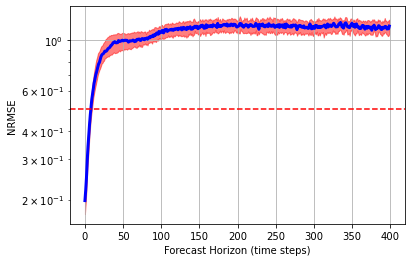

It takes around t = 0.08 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.818
Median NRMSE at t = 0.5: 0.990
Median NRMSE at t = 1: 1.078
Median NRMSE at t = 2: 1.141
Median NRMSE at t = 3: 1.130


In [27]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.5 Increased and Equal weightage to forward and backward dynamic [1, 1, 1, 0.01]

In [24]:
loss_weights = [1, 1, 1, 0.01]

In [25]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 20.08 | Train loss = 0.0442285 | Val loss =  1.5612148
Epoch 20: Time taken = 19.77 | Train loss = 0.0316364 | Val loss =  1.4932315
Epoch 30: Time taken = 20.01 | Train loss = 0.0257068 | Val loss =  1.5513136
EARLY STOPPING. Epoch 31: Train loss = 0.0254522 | Val loss =  1.5198995
Best Validation MSE: 1.0551192
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 19.94 | Train loss = 0.0410855 | Val loss =  1.6456842
Epoch 20: Time taken = 19.99 | Train loss = 0.0299650 | Val loss =  1.5659282
Epoch 30: Time taken = 19.95 | Train loss = 0.0251399 | Val loss =  1.5011453
EARLY STOPPING. Epoch 31: Train loss = 0.0245288 | Val loss =  1.4978310
Best Validation MSE: 1.3479354

Epoch 10: Time taken = 19.70 | Train loss = 0.0379404 | Val loss =  1.6013713
Epoch 20: Time taken = 20.01 | Train loss = 0.0288625 | Val loss =  1.5443070
Epoch 30: Time taken = 19.67 | Train loss = 0.0241156 | Val loss =  1.6155467
EARLY STOPPING. Epoch 31: Train loss = 0.

In [26]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.32


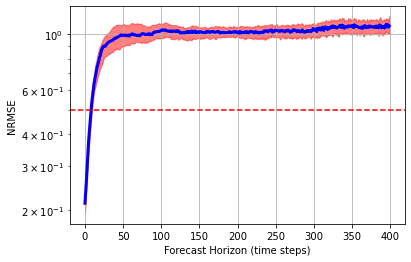

It takes around t = 0.09 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.819
Median NRMSE at t = 0.5: 0.990
Median NRMSE at t = 1: 1.033
Median NRMSE at t = 2: 1.017
Median NRMSE at t = 3: 1.037


In [27]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Final Model

In [64]:
hidden_size = [240, 240, 240, 240]
max_lag = 16
loss_weights = [1, 2, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [65]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 16.81 | Train loss = 0.0291803 | Val loss =  1.8258376
Epoch 20: Time taken = 16.88 | Train loss = 0.0194285 | Val loss =  2.0603582
Epoch 30: Time taken = 16.84 | Train loss = 0.0155865 | Val loss =  2.2002839
EARLY STOPPING. Epoch 31: Train loss = 0.0151016 | Val loss =  2.2039661
Best Validation MSE: 1.1228330
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 16.81 | Train loss = 0.0258383 | Val loss =  2.0490732
Epoch 20: Time taken = 16.80 | Train loss = 0.0179415 | Val loss =  2.1029486
Epoch 30: Time taken = 16.89 | Train loss = 0.0145165 | Val loss =  1.9193700
EARLY STOPPING. Epoch 37: Train loss = 0.0133581 | Val loss =  2.0598842
Best Validation MSE: 1.8240124

Epoch 10: Time taken = 16.82 | Train loss = 0.0191980 | Val loss =  1.9951384
Epoch 20: Time taken = 16.78 | Train loss = 0.0149842 | Val loss =  1.9969800
Epoch 30: Time taken = 16.85 | Train loss = 0.0127950 | Val loss =  2.1921878
Epoch 35: Time taken = 16.86 | Train loss

In [66]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.23


In [67]:
save_obj(params, res_folder, "best_params.pkl")

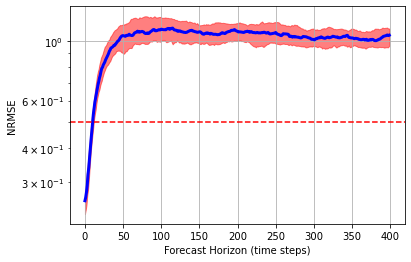

It takes around t = 0.11 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.745
Median NRMSE at t = 0.5: 1.046
Median NRMSE at t = 1: 1.105
Median NRMSE at t = 2: 1.085
Median NRMSE at t = 3: 1.011


In [68]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [12]:
hidden_size = [240, 240, 240, 240]

In [69]:
res_folder = os.path.join("results", "koopman")

In [14]:
def create_network(hidden_size):
    p1, p2, p3, kappa = hidden_size
    encoder_init, encoder = stax.serial(
        Dense(p1), Tanh,  
        Dense(p2), Tanh,
        Dense(p3), Tanh,
        Dense(kappa))
    decoder_init, decoder = stax.serial(
        Dense(p3), Tanh,
        Dense(p2), Tanh,
        Dense(p1), Tanh,
        Dense(data_dim))
    forward_init, forward = stax.serial(
        Dense_no_bias(kappa))
    backward_init, backward = stax.serial(
        Dense_no_bias(kappa))
    network = (encoder, decoder, forward, backward)
    return network

In [15]:
network = create_network(hidden_size)
params = load_obj(os.path.join(res_folder, "best_params.pkl"))

In [70]:
mean_pred = get_test_pred(X_test, params, network)
save_obj(mean_pred, "results", "koopman_pred.pkl")

Time taken: 0.22


In [71]:
mean_pred = load_obj("results/koopman_pred.pkl")

In [72]:
total_lyapunov_time_pred = 100 / KS_LT # Amount of Lyapunov Time in Test set

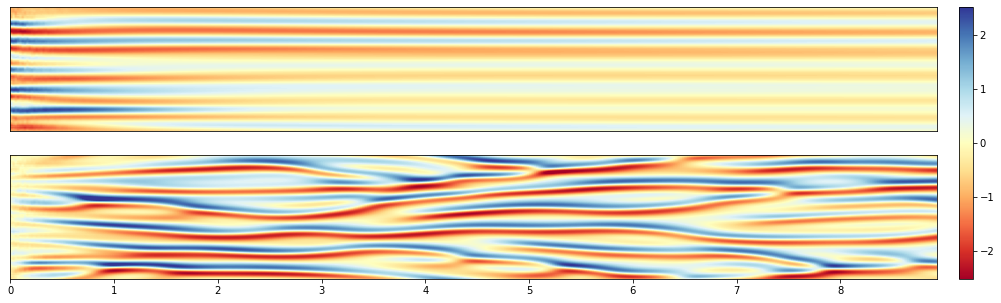

In [73]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "ks_koop_edited", pred_only=True)

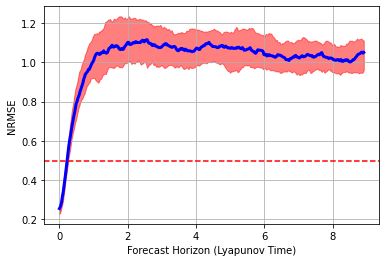

It takes around 0.25 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.791
Median NRMSE at 1.0 Lyapunov Time: 1.002
Median NRMSE at 2.0 Lyapunov Time: 1.099
Median NRMSE at 5.0 Lyapunov Time: 1.071


In [74]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "ks")
res_single.plot_rmse(save_name = "ks_koop_ph_edited")
print()
res_single.get_loss()